# PyTorch and Dask

### Defining models, datasets and functions

If you're doing something relatively simple, Dask has integrations with [Scikit-Learn](https://ml.dask.org/joblib.html) and [XGBoost](https://ml.dask.org/xgboost.html). You can also pass PyTorch models into Scikit-Learn with [Skorch](https://ml.dask.org/pytorch.html) and TensorFlow models with [SciKeras](https://ml.dask.org/keras.html).

But if you need to do something more complex, Dask clusters can have python functions submitted to them to remotely execute code.
This gives us the low level control to implement whatever bespoke algorithm we want and have it accelerated by remote GPUs.

In this example we're going to write our own PyTorch functions to train a custom model on the CIFAR dataset. While we could do this with Skorch, we hope that this example gives you some idea of how Dask can be flexible enough for any applications that you need.

Content adapted from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.multiprocessing as mp

# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Define dataset and dataloader
batch_size = 1024
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
validset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# Note that we need to set the multiprocessing context so that PyTorch doesn't get
# PyTorch likes to use 'forking' while Dask uses 'spawn'
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16, multiprocessing_context=mp.get_context("fork"))
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=True, num_workers=16, multiprocessing_context=mp.get_context("fork"))


Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define a simple conv net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(4 * 4 * 64, 4 * 64)
        self.fc2 = nn.Linear(4 * 64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

This train function will load any saved state for the provided model, then train for a number of epochs. When its done it will then save the state and return the average loss of the last epoch.

There are also a few flags which have been included to show the printing and error handling behaviour of dask clusters.

In [3]:
import torch.optim as optim
from tqdm.notebook import tqdm


# loader: train dataloader
# arch: model archetechture for training
# path: model path for load and save
# load: whether to load model from path
# save: whether to save model to path
# test: only run one batch for testing
# error: throw an assertion error
# return: average loss of epoch or loss of one batch if testing
def train(loader, arch=Net, path="./model", epochs=1, load=False, save=True, test=False, error=False):
    model = arch()
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load state from disk so that we can split up the job
    if load: 
        state = torch.load(path, map_location="cpu")
        model.load_state_dict(state["model"])
        model.to(device)
        optimizer.load_state_dict(state["optimizer"])
    else:
        model.to(device)
    
    # A typical PyTorch training loop
    model.train()
    for _ in range(epochs):
        running_loss = 0
        
        for i, (inputs, labels) in enumerate(loader):
            # put the inputs on the device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().item()
            
            # Force an error
            if error:
                assert 0 == 1
            
            # Stop after one batch when testing        
            if test: 
                print("When running in a local cluster you can see print statements")
                break
    
    # Save model after each epoch
    if save:
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
            }, path)
    
    return running_loss / len(loader) if not test else loss.detach().item()

This valid function will load the state of the model we've defined, then calculate the average loss and accuracy over the dataset.


In [4]:
# loader: train dataloader
# arch: model archetechture for validating
# path: model path for load and save
# return: average loss and accuracy of epoch
def valid(loader, arch=Net, path="./model"):
    # Initialise device
    model = arch()
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load state from disk so that we can split up the job
    state = torch.load(path, map_location="cpu")
    model.load_state_dict(state["model"])
    model.to(device)
    model.eval()
    
    # A typical PyTorch validation loop
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            # put the inputs on the device
            inputs, labels = inputs.to(device), labels.to(device)

            # forward
            outputs = model(inputs)
            
            # loss
            loss = criterion(outputs, labels)
            running_loss += loss.detach().item()
            
            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(loader), correct / total


### Testing with a `LocalCluster`

Dask LocalClusters are easiest to use interactive development. This will mean that code will execute in the notebook session allowing you to view print statements and debug errors normally rather than dealing with remote code execusion before we're ready. Later, when you are satisfied with your code you can switch over to a SLURMCluster to accelerate with GPU.


Dask prefers to control all processes so that it can manage them more gracefully if they fail, but we need to give PyTorch the control to use multiprocessing as needed. To do this set `proccesses=False` to allow for multiprocessing inside Dask jobs.

In [23]:
from distributed import Client, LocalCluster

cluster = LocalCluster(processes=False)
client = Client(cluster)
client


/userdata/mhar0048/miniconda/conda/envs/dask/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41665 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.213:41665/status,
Dashboard: http://192.168.0.213:41665/status,Workers: 1
Total threads: 20,Total memory: 590.14 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.213/387069/1,Workers: 1
Dashboard: http://192.168.0.213:41665/status,Total threads: 20
Started: Just now,Total memory: 590.14 GiB
Comm: inproc://192.168.0.213/387069/4,Total threads: 20
Dashboard: http://192.168.0.213:36253/status,Memory: 590.14 GiB
Nanny: None,


We can submit our function to the cluster with the `client.submit` method. This will return a future which can be unpacked with its result using `future.result()`. We can see the outputs of print statements while we're using a `LocalCluster`. Print statements will not be visible when executing remotely with `SLURMCluster`.

In [24]:
future = client.submit(train, trainloader, test=True)
future.result()

/userdata/mhar0048/miniconda/conda/envs/dask/lib/python3.10/site-packages/distributed/worker.py:2845: UserWarning: Large object of size 146.58 MiB detected in task graph: 
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


When running in a local cluster you can see print statements


2.3040761947631836

We can use the `client.scatter` method to scatter large objects out to our workers ahead of time for more efficient execution.

In [30]:
trainloader_future = client.scatter(trainloader)
client.submit(train, trainloader, test=True).result()


When running in a local cluster you can see print statements


2.3033735752105713

In [25]:
client.shutdown()


### Training with a `SLURMCluster`

Dask usually uses a 'nanny' that monitors any worker processes and gracefully restarts them if they fail or are killed while performing computations. The nanny is not compatable with daemonic processes - that is dask workers cannot perform multiprocessing while it's being used. We therefore need to set `nanny=False` to turn off the nanny to allow for multiprocessing inside Dask jobs for the cluster to work with PyTorch. (Just like when we `processes=False` for the `LocalCluster`.)

We can pass in extra SLURM requirements in job_extra_directives to request a GPU for our jobs. To read more about configuring the `SLURMCluster` to interact with the SLURM queue, go to Dask's [jobqueue documentation](https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SLURMCluster.html?highlight=slurmcluster).


In [8]:
from dask_jobqueue import SLURMCluster
from distributed import Client
cluster = SLURMCluster(
    memory="190g", processes=1, cores=20, job_extra_directives=["--gres=gpu:1"], nanny=False
)

cluster.scale(1)
client = Client(cluster)

/userdata/mhar0048/miniconda/conda/envs/dask/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34527 instead
  warnings.warn(


Since this code is executing remotely we won't see our print statements

In [9]:
trainloader_future = client.scatter(trainloader)
client.submit(train, trainloader_future, test=True).result()


2.3033061027526855

Dask will raise any errors that the process triggers locally, even when executing remotely

In [10]:
trainloader_future = client.scatter(trainloader)
client.submit(train, trainloader_future, error=True).result()


AssertionError: 

Finally we can bring everything together and run our training loop.

In [29]:
# Run the training loop
epochs = 5
trainloader_future = client.scatter(trainloader)
validloader_future = client.scatter(validloader)
with tqdm(total=(epochs)) as pbar:
    for epoch in range(epochs):
        train_loss = client.submit(train, trainloader_future, load=(epoch > 0)).result()
        valid_loss, accuracy = client.submit(valid, validloader_future).result()
        pbar.update()
        pbar.set_postfix(loss=train_loss)
        print( f"epoch: {epoch}, train_loss: {train_loss : .3f}, valid_loss: {valid_loss : .3f}, accuracy: {accuracy : .3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0, train_loss:  2.271, valid_loss:  2.142, accuracy:  0.206
epoch: 1, train_loss:  2.019, valid_loss:  1.934, accuracy:  0.284
epoch: 2, train_loss:  1.897, valid_loss:  1.834, accuracy:  0.322
epoch: 3, train_loss:  1.816, valid_loss:  1.766, accuracy:  0.344
epoch: 4, train_loss:  1.750, valid_loss:  1.700, accuracy:  0.368


### Measuring Dask's overhead

Offloading tasks to Dask doesn't come for free, there is an initial cost associated with sending the data to a remote device. Let's compare the time it would take to train a Resnet18 on CIFAR for a range of epochs comparing a local GPU, a remote GPU using Dask and a remote GPU using Dask with a scattered dataset. For this expriment we will not bother saving the weights afterwards since this should be relatively constant between methods.

In [12]:
from torchvision.models import resnet18
from time import time

# Store times in arrays
local = []
remote = []
scatter = []

# Test some number of epochs
epoch_list = [1, 2, 3, 5, 10]
with tqdm(total=(len(epoch_list) * 3)) as pbar:
    for num_epochs in epoch_list:
        
        # Local GPU
        start = time()
        train(trainloader, arch=resnet18, epochs=(num_epochs + 1), save=False)
        local.append(time() - start)
        pbar.update()
        
        # Remote GPU
        start = time()
        client.submit(train, trainloader, arch=resnet18, epochs=(num_epochs + 1), save=False).result()
        remote.append(time() - start)
        pbar.update()
        
        # Remote GPU with scatter
        start = time()
        trainloader_future = client.scatter(trainloader)
        client.submit(train, trainloader_future, arch=resnet18, epochs=(num_epochs + 1), save=False).result()
        scatter.append(time() - start)
        pbar.update()


  0%|          | 0/15 [00:00<?, ?it/s]

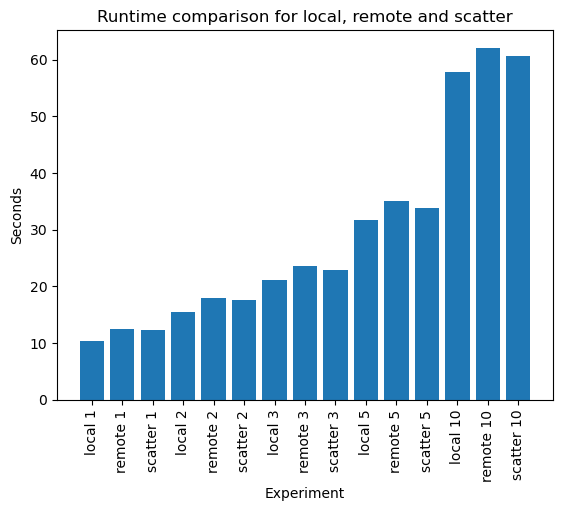

In [13]:
import matplotlib.pyplot as plt
from itertools import chain

data = list(chain(*zip(local, remote, scatter)))
columns = []
for num_epochs in epoch_list:
    for test in ["local", "remote", "scatter"]:
        columns.append(test + " " + str(num_epochs))

plt.bar(range(len(data)), data, tick_label=columns)
plt.xticks(rotation=90)
plt.xlabel("Experiment")
plt.ylabel("Seconds")
plt.title("Runtime comparison for local, remote and scatter")
plt.show()

From this experiment we can see that the cost associated with running code remotely is small, and the impact decreases with the size of the function that we submit. It also shows that it always makes sense to scatter large objects before computing, even for small jobs.

In [ ]:
client.shutdown()